In [27]:
import pandas
import cv2
from matplotlib import pyplot
from Bio import SeqIO, AlignIO

In [28]:
data_dir = "../../../data"
big_one = "homo_sapiens_ENSG00000165553"
small_one = "carlito_syrichta_ENSTSYG00000026821"
dataset = "orthologs_neuroglobin"
algorithm = "MultiScale Structural Similarity Index Measure"

In [29]:
df = pandas.read_csv(f"{data_dir}/trees/full/{dataset}/{algorithm}.map")

In [30]:
df.head()

,img1,img2,score,start_col,start_line,stop_col,stop_line,max_size
0,homo_sapiens_ENSG00000165553.png,homo_sapiens_ENSG00000165553.png,1.000000,0,0,456,456,456
1,homo_sapiens_ENSG00000165553.png,chlorocebus_sabaeus_ENSCSAG00000011845.png,0.939997,0,0,456,456,456
2,homo_sapiens_ENSG00000165553.png,otolemur_garnettii_ENSOGAG00000006194.png,0.828863,0,0,456,456,456
3,homo_sapiens_ENSG00000165553.png,nomascus_leucogenys_ENSNLEG00000016682.png,0.985417,0,0,456,456,456
4,homo_sapiens_ENSG00000165553.png,prolemur_simus_ENSPSMG00000011006.png,0.871896,0,0,456,456,456


In [31]:
df_filter_test = df[(df.img1 == f"{big_one}.png") & (df.img2 == f"{small_one}.png")]
df_filter_test.head()

,img1,img2,score,start_col,start_line,stop_col,stop_line,max_size
39,homo_sapiens_ENSG00000165553.png,carlito_syrichta_ENSTSYG00000026821.png,0.056028,0,0,417,417,456
40,homo_sapiens_ENSG00000165553.png,carlito_syrichta_ENSTSYG00000026821.png,0.023251,1,1,418,418,456
41,homo_sapiens_ENSG00000165553.png,carlito_syrichta_ENSTSYG00000026821.png,0.000000,2,2,419,419,456
42,homo_sapiens_ENSG00000165553.png,carlito_syrichta_ENSTSYG00000026821.png,0.037127,3,3,420,420,456
43,homo_sapiens_ENSG00000165553.png,carlito_syrichta_ENSTSYG00000026821.png,0.000000,4,4,421,421,456


In [32]:
df_filter_test.score.describe()

count    40.000000
mean      0.053423
std       0.068597
min       0.000000
25%       0.022736
50%       0.041239
75%       0.068150
max       0.438322
Name: score, dtype: float64

In [33]:
if algorithm == "MultiScale Structural Similarity Index Measure":
    df_filter_test = df_filter_test[df_filter_test.score == df_filter_test.score.max()]

In [34]:
dict_filter_test = df_filter_test.to_dict("records")
dict_filter_test

[{'img1': 'homo_sapiens_ENSG00000165553.png',
  'img2': 'carlito_syrichta_ENSTSYG00000026821.png',
  'score': 0.43832222,
  'start_col': 6,
  'start_line': 6,
  'stop_col': 423,
  'stop_line': 423,
  'max_size': 456}]

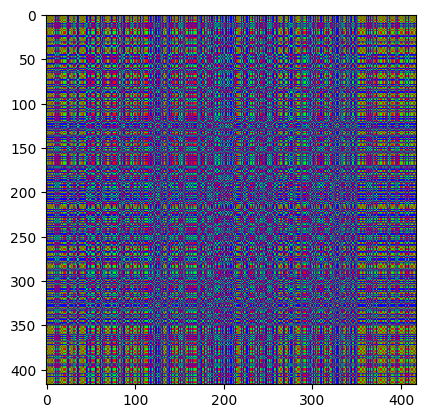

In [35]:
img2 = cv2.imread(f"{data_dir}/images/{dataset}/full/{small_one}.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
pyplot.imshow(img2)

{'img1': 'homo_sapiens_ENSG00000165553.png', 'img2': 'carlito_syrichta_ENSTSYG00000026821.png', 'score': 0.43832222, 'start_col': 6, 'start_line': 6, 'stop_col': 423, 'stop_line': 423, 'max_size': 456}


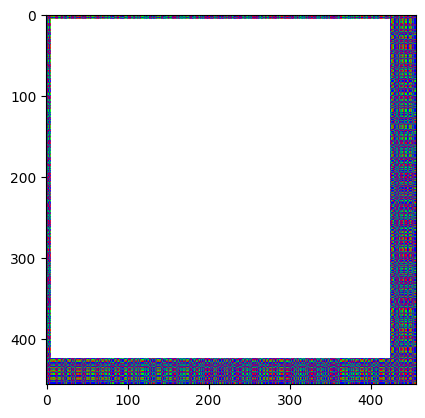

In [36]:
img = cv2.imread(f"{data_dir}/images/{dataset}/full/{big_one}.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for i in dict_filter_test:
    print(i)
    cv2.rectangle(img, (i["start_col"], i["start_line"]), (i["stop_col"], i["stop_line"]), (255,255,255), -1)
pyplot.imshow(img)

## Try to "align"

In [37]:
seqs = SeqIO.parse(f"{data_dir}/{dataset}.fasta.sanitized", "fasta")
to_align = []
for s in seqs:
    if s.description == big_one:
        big_img = (s.description, s.seq)
        to_align.append(big_img)
    elif s.description == small_one:
        small_img = (s.description, s.seq)
        to_align.append(small_img)
to_align

[('homo_sapiens_ENSG00000165553',
  Seq('ATGGAGCGCCCGGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGCAGTGAGCCGC...TAA')),
 ('carlito_syrichta_ENSTSYG00000026821',
  Seq('CGCGCGCCGCTCTCTCCGCGGGGCTTCCGCGAGGCTTGGCGCCGGAACCAACCC...CCG'))]

In [38]:
alignment = ""
last_col = 0
last_line = 0
start_write = 0
stop_write = 0
for i, row in df_filter_test.iterrows():
    if row["start_col"] < last_col:
        gap = 0
        stop_write += row["stop_col"] - last_col
    else:
        gap = row["start_col"] - last_col
        if not gap:
            gap = row["start_line"] - last_line
        stop_write = row["stop_col"] - row["start_col"]
    stop_write = row["stop_col"]
    alignment += gap * "-"
    alignment += str(small_img[1])[start_write:stop_write]
    last_col = row["stop_col"]
    last_line = row["start_line"]
    start_write = stop_write
alignment += (row["max_size"] - last_col) * "-"

In [39]:
alignment

'------CGCGCGCCGCTCTCTCCGCGGGGCTTCCGCGAGGCTTGGCGCCGGAACCAACCCCTAGGGCTGACACCCGGCCAACCCCACAGGCTGTTCGCCCTGGAGCCCGACCTGCTGCCCCTCTTCCAGTACAACTGTCGCCAGTTCTCCAGCCCAGAGGACTGCCTCTCCTCCCCTGAGTTCCTGGACCACATCAGGAAGGTGATGCTTGTGATTGACACCGCGGTGACCAATGTGGAGGACCTGTCCTCACTTGAGGAGTACCTTGCCGGCTTGGGCAGAAAGCACCGGGCAGTGGGTGTGAAGCTCAGCTCCTTCTCGGTGAGCCTACTGTATGCAGAGGCTGTGCTAGGATCTGGGCCGGCCGTCTCTCCAGCCACGCGGGCCGCCTGGAGCCCGCTCTCCGGGCCGTGGTGCGGGCCG---------------------------------'

In [40]:
str(small_img[1])

'CGCGCGCCGCTCTCTCCGCGGGGCTTCCGCGAGGCTTGGCGCCGGAACCAACCCCTAGGGCTGACACCCGGCCAACCCCACAGGCTGTTCGCCCTGGAGCCCGACCTGCTGCCCCTCTTCCAGTACAACTGTCGCCAGTTCTCCAGCCCAGAGGACTGCCTCTCCTCCCCTGAGTTCCTGGACCACATCAGGAAGGTGATGCTTGTGATTGACACCGCGGTGACCAATGTGGAGGACCTGTCCTCACTTGAGGAGTACCTTGCCGGCTTGGGCAGAAAGCACCGGGCAGTGGGTGTGAAGCTCAGCTCCTTCTCGGTGAGCCTACTGTATGCAGAGGCTGTGCTAGGATCTGGGCCGGCCGTCTCTCCAGCCACGCGGGCCGCCTGGAGCCCGCTCTCCGGGCCGTGGTGCGGGCCG'

In [41]:
big_str = str(big_img[1])
big_str

'ATGGAGCGCCCGGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGCAGTGAGCCGCAGCCCGCTGGAGCACGGCACCGTCCTGTTTGCCAGGCTGTTTGCCCTGGAGCCTGACCTGCTGCCCCTCTTCCAGTACAACTGCCGCCAGTTCTCCAGCCCAGAGGACTGTCTCTCCTCGCCTGAGTTCCTGGACCACATCAGGAAGGTGATGCTCGTGATTGATGCTGCAGTGACCAATGTGGAAGACCTGTCCTCACTGGAGGAGTACCTTGCCAGCCTGGGCAGGAAGCACCGGGCAGTGGGTGTGAAGCTCAGCTCCTTCTCGACAGTGGGTGAGTCTCTGCTCTACATGCTGGAGAAGTGTCTGGGCCCTGCCTTCACACCAGCCACACGGGCTGCCTGGAGCCAACTCTACGGGGCCGTAGTGCAGGCCATGAGTCGAGGCTGGGATGGCGAGTAA'

In [42]:
final_align = ""
score = 0
for i, letter in enumerate(alignment):
    if (letter == "-"):
        final_align += letter
    elif (letter == big_str[i]):
        final_align += "*"
        score += 1
    else:
        final_align += letter
final_align

'------***G**CC**T*TCT*C*CGGG*CTTCC**GA*GCTTGGCGCC*GAA*CAA**C**A*G**TGACAC***G**AACCCCA*********C***********C*****************************T**************************C********C***********************************T********CA*C**G**************G**************T***************G**T*******A***************************************GTGAGCCTACT**A*GCAGAGGCTG****A*GATCTG*G*C**C*GTCT*TCCAG*CA*GCGGG*CGCCTGGAG*CC*CT*TCCGGGCCGT**TG**GGCC*---------------------------------'

In [43]:
score / len(big_str) * 100  # identity 

59.86842105263158

### With Clustal Multiple Alignment

In [44]:
to_align

[('homo_sapiens_ENSG00000165553',
  Seq('ATGGAGCGCCCGGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGCAGTGAGCCGC...TAA')),
 ('carlito_syrichta_ENSTSYG00000026821',
  Seq('CGCGCGCCGCTCTCTCCGCGGGGCTTCCGCGAGGCTTGGCGCCGGAACCAACCC...CCG'))]

In [45]:
align = AlignIO.read(f"{data_dir}/trees/full/{dataset}/Control with Clustal Omega.fasta", "fasta")
print(align)

Alignment with 15 rows and 456 columns
ATGGAGCGCCCGGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGC...TAA homo_sapiens_ENSG00000165553
ATGGAGCGCCCAGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGC...TAA chlorocebus_sabaeus_ENSCSAG00000011845
ATGGAGCGCCCGGAGCCGGAGCTGATCCGGCAGAGCTGGCAAGC...TGA otolemur_garnettii_ENSOGAG00000006194
ATGGAGCGCCCGGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGC...TAA nomascus_leucogenys_ENSNLEG00000016682
ATGGAGCGCCCGGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGC...TGA prolemur_simus_ENSPSMG00000011006
ATGGAGCCCCCGGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGC...TAA aotus_nancymaae_ENSANAG00000022420
ATGGACCGCCCGGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGC...TAA gorilla_gorilla_ENSGGOG00000006195
ATGGAGCGCCCGGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGC...TAA pan_troglodytes_ENSPTRG00000006575
ATGGAGCGCCCAGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGC...TAA rhinopithecus_roxellana_ENSRROG00000044996
ATGGAGCGCCCAGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGC...TAA rhinopithecus_bieti_ENSRBIG00000038926
ATGGAGCGCCCGGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGC...TAA pan_paniscus_ENSPPAG00000040520
--

In [46]:
for a in align:
    if a.description == big_one:
        big_str_clustal = str(a.seq)
big_str_clustal

'ATGGAGCGCCCGGAGCCCGAGCTGATCCGGCAGAGCTGGCGGGCAGTGAGCCGCAGCCCGCTGGAGCACGGCACCGTCCTGTTTGCCAGGCTGTTTGCCCTGGAGCCTGACCTGCTGCCCCTCTTCCAGTACAACTGCCGCCAGTTCTCCAGCCCAGAGGACTGTCTCTCCTCGCCTGAGTTCCTGGACCACATCAGGAAGGTGATGCTCGTGATTGATGCTGCAGTGACCAATGTGGAAGACCTGTCCTCACTGGAGGAGTACCTTGCCAGCCTGGGCAGGAAGCACCGGGCAGTGGGTGTGAAGCTCAGCTCCTTCTCGACAGTGGGTGAGTCTCTGCTCTACATGCTGGAGAAGTGTCTGGGCCCTGCCTTCACACCAGCCACACGGGCTGCCTGGAGCCAACTCTACGGGGCCGTAGTGCAGGCCATGAGTCGAGGCTGGGATGGCGAGTAA'

In [47]:
for a in align:
    if a.description == small_one:
        alignment_clustal = str(a.seq)
alignment_clustal

'------CGCGCGCCGCTCTCTCCGCGGGGCTTCCGCGAGGCTTGGCGCCGGAACCAACCCCTAGGGCTGACACCCGGCCAACCCCACAGGCTGTTCGCCCTGGAGCCCGACCTGCTGCCCCTCTTCCAGTACAACTGTCGCCAGTTCTCCAGCCCAGAGGACTGCCTCTCCTCCCCTGAGTTCCTGGACCACATCAGGAAGGTGATGCTTGTGATTGACACCGCGGTGACCAATGTGGAGGACCTGTCCTCACTTGAGGAGTACCTTGCCGGCTTGGGCAGAAAGCACCGGGCAGTGGGTGTGAAGCTCAGCTCCTTCTCGGTGAGCCTACTGTATGCAGAGGCTGTGCTAGG------ATCTGGGCCGGCCGTCTCTCCAGCCACGCGGGCCGCCTGGAGCCCGCTCTCCGGGCCGTGGTGCGGGCCG---------------------------'

[6, 359] [352, 428]


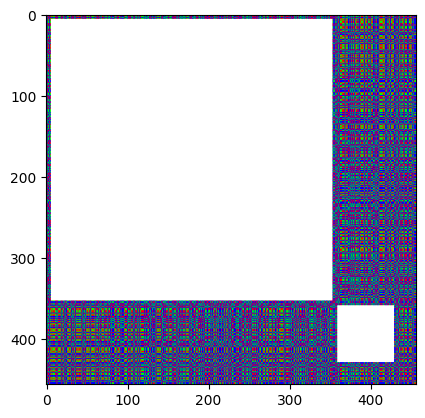

In [48]:
img = cv2.imread(f"{data_dir}/images/{dataset}/full/{big_one}.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
start_col = []
stop_col = []
for i, letter in enumerate(alignment_clustal):
    if (letter != "-") and (len(start_col) == len(stop_col)):
        start_col.append(i)        
    elif (letter == "-") and (len(start_col) > len(stop_col)):
        stop_col.append(i-1)
print(start_col, stop_col)
for j in range(len(start_col)):
    cv2.rectangle(img, (start_col[j], start_col[j]), (stop_col[j], stop_col[j]), (255,255,255), -1)
pyplot.imshow(img)

In [49]:
final_align_clustal = ""
score_clustal = 0
for i, letter in enumerate(alignment_clustal):
    if (letter == "-"):
        final_align_clustal += letter
    elif (letter == big_str_clustal[i]):
        final_align_clustal += "*"
        score_clustal += 1
    else:
        final_align_clustal += letter
final_align_clustal

'------***G**CC**T*TCT*C*CGGG*CTTCC**GA*GCTTGGCGCC*GAA*CAA**C**A*G**TGACAC***G**AACCCCA*********C***********C*****************************T**************************C********C***********************************T********CA*C**G**************G**************T***************G**T*******A***************************************GTGAGCCTACT**A*GCAGAGGCTG****A*G------ATCT**G**G***G**T*T********G*****C**********CG****C****C*GTGGTGCGG*C*G---------------------------'

In [50]:
score_clustal / len(big_str_clustal) * 100  # identity 

65.78947368421053

### Comparing with Clustal

In [51]:
final_align_compare = ""
score_compare = 0
for i, letter in enumerate(alignment):
    if (letter == alignment_clustal[i]):
        final_align_compare += "*"
        score_compare += 1
    else:
        final_align_compare += letter
final_align_compare

'*****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************ATCTGGGC*G*CCGTCT*TCCAG*CA*GCGGG*CGCCTGGAG*CC*CT*T*CGGGC*GT**TGCG**CCG------***************************'

In [52]:
score_compare / len(alignment_clustal) * 100

86.62280701754386